**Objective:**
The project aims to explore various time series forecasting techniques to predict daily sales for 50 products across 10 stores for the upcoming month. The dataset includes 5 years of historical sales data, and the task is to identify the most accurate model for this forecasting challenge. The focus is on experimenting with different models from the Darts library and evaluating their performance using the Mean Absolute Percentage Error (MAPE) metric.

**Scope:**
A range of time series models will be tested, including:
*   NaiveSeasonal
*   NaiveDrift
*   XGBModel
*   ExponentialSmoothing
*   ARIMA
*   AutoARIMA
*   Prophet
*   RNNModel

The goal is to conduct a thorough comparison of these models to identify the best performer in terms of accuracy for predicting daily sales.

**Dataset:**
https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 16.9 MB/s eta 0:00:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from statsmodels.graphics.tsaplots import plot_pacf
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveSeasonal, NaiveDrift
from darts.metrics import mape
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.models import ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv.zip')

In [ ]:
df.head(), df.shape

(         date  store  item  sales
 0  2013-01-01      1     1     13
 1  2013-01-02      1     1     11
 2  2013-01-03      1     1     14
 3  2013-01-04      1     1     13
 4  2013-01-05      1     1     10,
 (913000, 4))

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


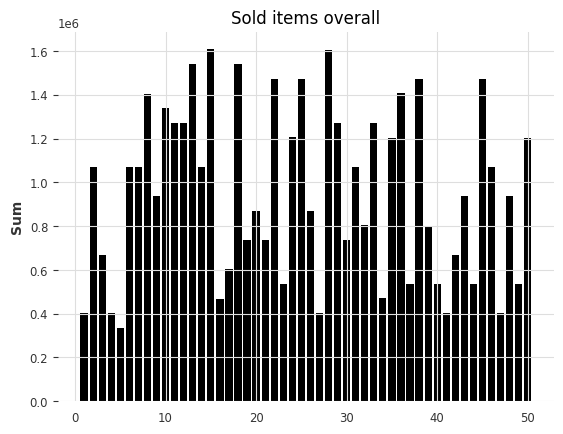

In [ ]:
fig, ax = plt.subplots()

ax.bar(df.groupby('item').sales.sum().index, df.groupby('item').sales.sum())

ax.set_ylabel('Sum')
ax.set_title('Sold items overall')

plt.show()

In [ ]:
df_mean_sales_by_item = pd.pivot_table(df, values='sales', index=['date'], columns=['item'], aggfunc="mean")
df_mean_sales_by_item.head(5)

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13.3,32.7,17.2,10.2,8.3,28.8,27.8,41.6,24.5,37.8,...,10.3,19.5,25.3,15.4,39.6,31.9,11.6,27.7,15.9,33.0
2013-01-02,9.9,27.9,21.3,11.0,8.1,31.0,29.1,38.6,22.5,39.7,...,13.2,21.5,25.5,16.5,39.3,31.6,11.8,28.1,15.9,38.4
2013-01-03,12.7,30.4,19.3,11.2,9.6,30.9,32.4,39.8,26.5,38.8,...,13.1,21.5,30.6,17.0,45.9,32.5,10.4,28.0,18.7,35.6
2013-01-04,14.5,35.9,21.8,13.8,10.8,34.3,33.5,43.0,31.3,46.2,...,12.2,22.4,32.3,18.9,45.0,35.1,12.8,29.6,18.4,39.4
2013-01-05,14.9,37.7,21.7,14.4,10.0,34.3,37.7,48.1,31.9,44.9,...,14.2,24.3,30.9,20.2,53.3,36.0,13.3,34.4,17.9,40.7


In [ ]:
df_min_sales_by_item = pd.pivot_table(df, values='sales', index=['date'], columns=['item'], aggfunc="min")
df_max_sales_by_item = pd.pivot_table(df, values='sales', index=['date'], columns=['item'], aggfunc="max")

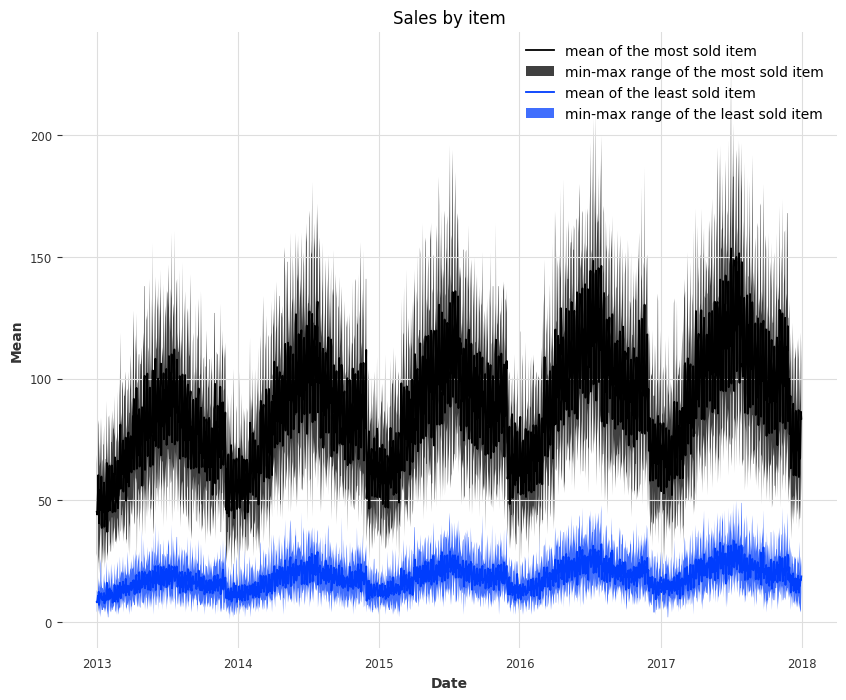

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df_mean_sales_by_item.index, df_mean_sales_by_item[15])
ax.fill_between(df_mean_sales_by_item.index, df_min_sales_by_item[15],df_max_sales_by_item[15], alpha=0.75)
ax.plot(df_mean_sales_by_item.index, df_mean_sales_by_item[5])
ax.fill_between(df_mean_sales_by_item.index, df_min_sales_by_item[5],df_max_sales_by_item[5], alpha=0.75)

ax.set_xlabel('Date')
ax.set_ylabel('Mean')
ax.legend(['mean of the most sold item','min-max range of the most sold item','mean of the least sold item', 'min-max range of the least sold item'])
ax.set_title('Sales by item')

plt.show()

Based on the sales charts of the top-selling and lowest-selling products, clear seasonality and a subtle trend are observed. Additionally, towards the end of each year, recurring "spikes" in sales are noticeable, which could potentially be linked to local holidays.

It can be assumed that similar patterns of seasonality and trends could be identified in the remaining 48 products as well.

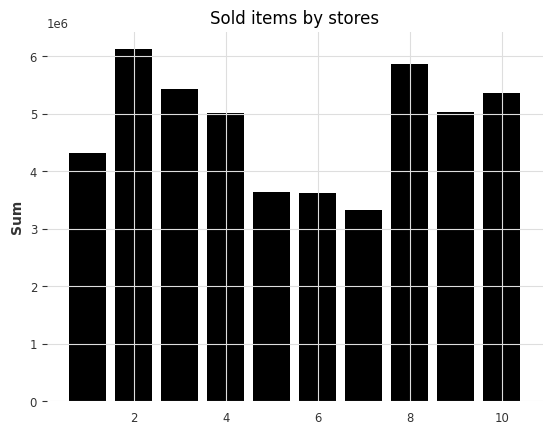

In [ ]:
fig, ax = plt.subplots()

ax.bar(df.groupby('store').sales.sum().index, df.groupby('store').sales.sum())

ax.set_ylabel('Sum')
ax.set_title('Sold items by stores')

plt.show()

In [ ]:
df_mean_sales_by_store = pd.pivot_table(df, values='sales', index=['date'], columns=['store'], aggfunc="mean")
df_min_sales_by_store = pd.pivot_table(df, values='sales', index=['date'], columns=['store'], aggfunc="min")
df_max_sales_by_store = pd.pivot_table(df, values='sales', index=['date'], columns=['store'], aggfunc="max")

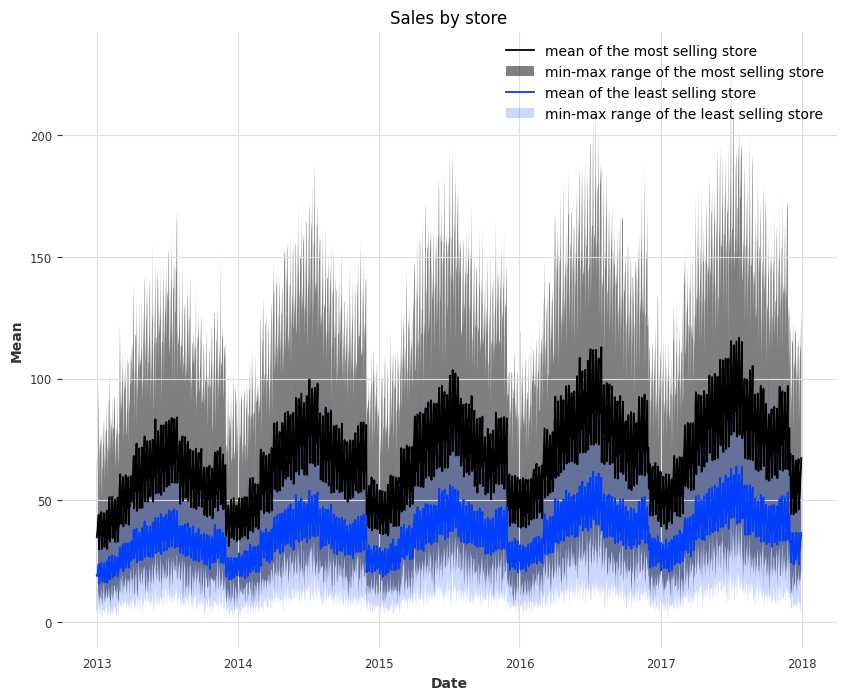

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df_mean_sales_by_store.index, df_mean_sales_by_store[2])
ax.fill_between(df_mean_sales_by_store.index, df_min_sales_by_store[2],df_max_sales_by_store[2], alpha=0.5)
ax.plot(df_mean_sales_by_store.index, df_mean_sales_by_store[7])
ax.fill_between(df_mean_sales_by_store.index, df_min_sales_by_store[7],df_max_sales_by_store[7], alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Mean')
ax.legend(['mean of the most selling store','min-max range of the most selling store','mean of the least selling store', 'min-max range of the least selling store'])
ax.set_title('Sales by store')

plt.show()

There is clear evidence of seasonality and a noticeable, albeit modest, trend in stores with both the highest and lowest sales.

It can be reasonably assumed that similar patterns are present in the other stores as well.

In [ ]:
df_1i_1s = df['sales'][(df['item']==1) & (df['store']==1)]

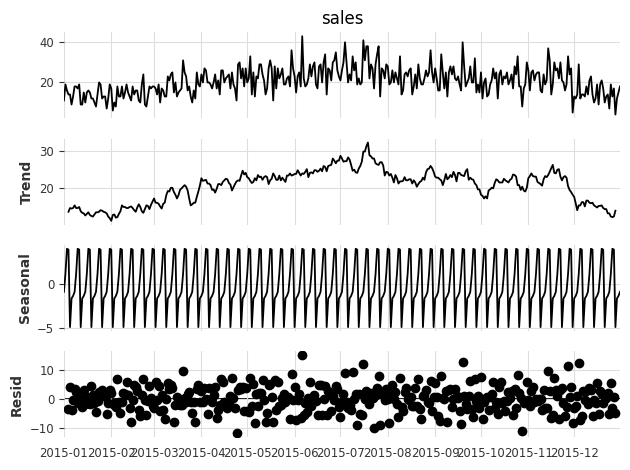

In [ ]:
decomposition_plot = seasonal_decompose(df_1i_1s[(df_1i_1s.index > '2014-12-31') & (df_1i_1s.index < '2016-01-01')],
                                        model='additive')
decomposition_plot.plot()
plt.show()

When narrowing the display range, seasonality becomes clearly visible in the chart. Additionally, it is evident that there is no significant trend. The residuals are centered around zero, which is a positive indication.

In [ ]:
ts = TimeSeries.from_series(df_1i_1s)

<Axes: xlabel='date'>

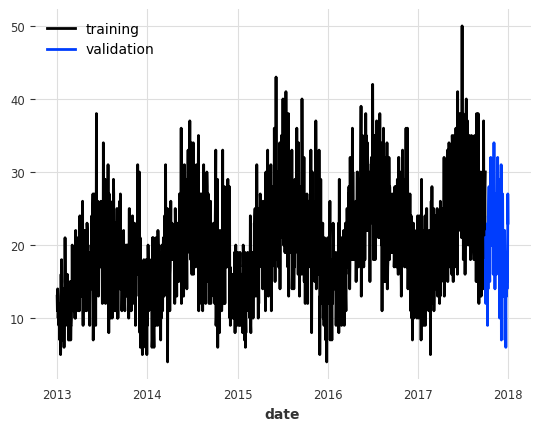

In [ ]:
train, val = ts.split_before(pd.Timestamp("2017-10-01"))
train.plot(label="training")
val.plot(label="validation")

<Figure size 1000x600 with 0 Axes>

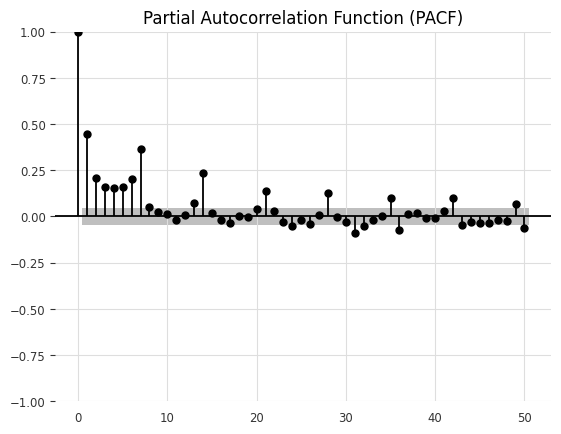

In [ ]:
plt.figure(figsize=(10, 6))
plot_pacf(df_1i_1s, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

The first 7 lags, as well as every 7th lag thereafter, are statistically significant and play a crucial role in forecasting.

In [ ]:
for m in range(2, 10):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.


This is supported by the partial autocorrelation analysis.

### Fitting Naive Models

<Axes: xlabel='date'>

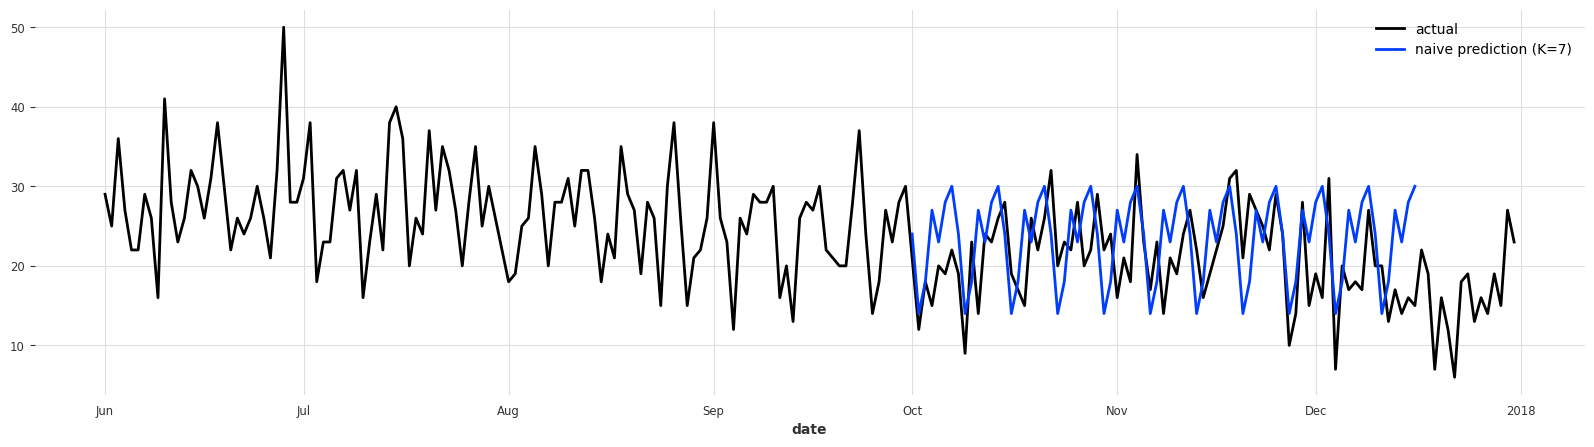

In [ ]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(77)

plt.figure(figsize=(20, 5))
ts.slice(pd.Timestamp('2017-06-01'), pd.Timestamp('2018-02-01')).plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=7)")

<Axes: xlabel='date'>

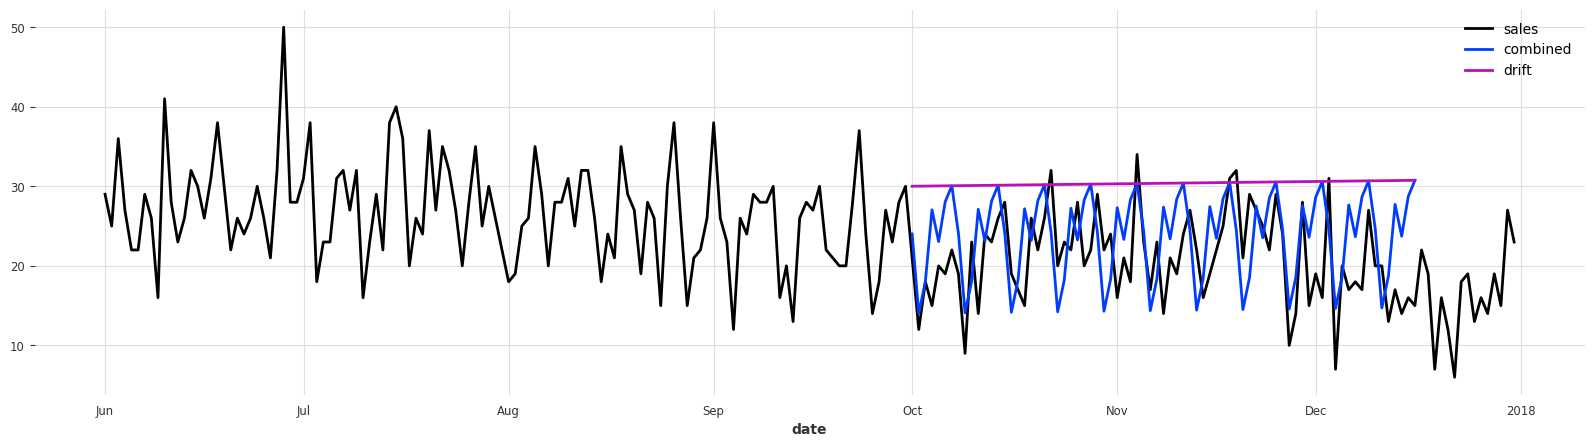

In [ ]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(77)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

plt.figure(figsize=(20, 5))
ts.slice(pd.Timestamp('2017-06-01'), pd.Timestamp('2018-02-01')).plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [ ]:
print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(val, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 33.01%.


### Fitting and Comparing Multiple Models

In [ ]:
def plot_results(series, forecast):
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

In [ ]:
def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

In [ ]:
def enrich_with_date_features(df, column):
  df["quarter"] = df[column].dt.quarter
  df["month"] = df[column].dt.month
  df["year"] = df[column].dt.year
  df["dayofyear"] = df[column].dt.dayofyear
  return df

train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index(), 'date')
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index(), 'date')

scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

model = XGBModel(lags=7)
model.fit(train_transformed)

XGBModel(lags=7, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [ ]:
ts_sliced_for_visual = ts.slice(pd.Timestamp('2017-06-01'), pd.Timestamp('2018-02-01'))

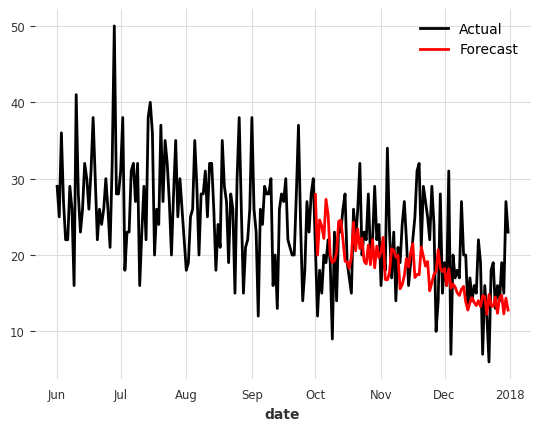

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 26.69%


In [ ]:
forecast = scaler.inverse_transform(model.predict(len(val)))
plot_results(ts_sliced_for_visual, forecast)
eval_forecast(model, val, forecast);

Based on the chart and the MAPE metric, this model demonstrates better performance. To achieve even better results, further hyperparameter tuning is necessary.

In [ ]:
def fit_eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    plot_results(ts_sliced_for_visual,forecast)
    eval_forecast(model, val, forecast)

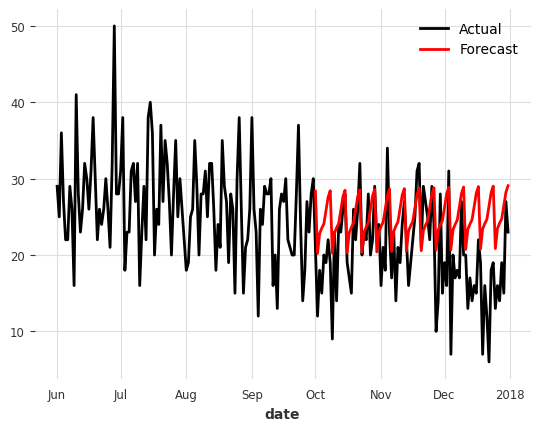

model ExponentialSmoothing() obtains MAPE: 39.01%


In [ ]:
fit_eval_model(ExponentialSmoothing())

Both the chart and the metric indicate poor model performance. Adjusting the parameters may be necessary for improvement.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


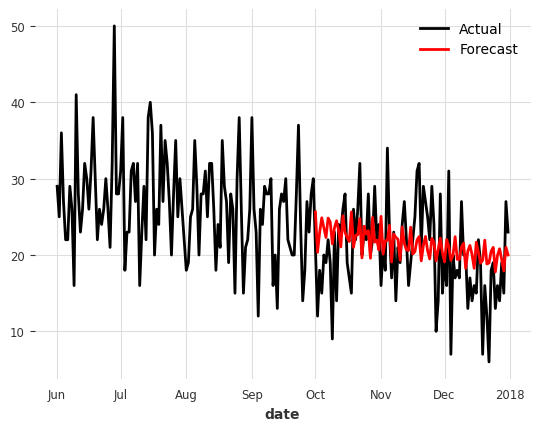

model ARIMA(p=7, d=3, q=7) obtains MAPE: 28.81%


In [ ]:
fit_eval_model(ARIMA(p=7, d=3, q=7))

This model performs better than some of the previous ones, but it is still inferior to XGBoost.

In [ ]:
model = AutoARIMA(start_p=1, max_p=15, start_q=1)
model.fit(train)

AutoARIMA(add_encoders=None, start_p=1, max_p=15, start_q=1)

In [ ]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Thu, 10 Oct 2024   AIC                          10591.078
Time:                        14:36:12   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

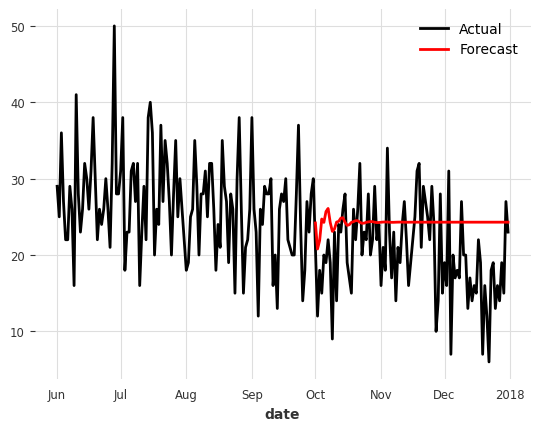

model ARIMA(p=7, q=1) obtains MAPE: 39.53%


In [ ]:
fit_eval_model(ARIMA(p=7, d=1, q=1))

The results have not improved compared to the manually tuned model.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxeeeqz7h/v79qciv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxeeeqz7h/ojs2sukn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=100', 'data', 'file=/tmp/tmpxeeeqz7h/v79qciv8.json', 'init=/tmp/tmpxeeeqz7h/ojs2sukn.json', 'output', 'file=/tmp/tmpxeeeqz7h/prophet_modelrcuvhf09/prophet_model-20241010143635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:36:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:36:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


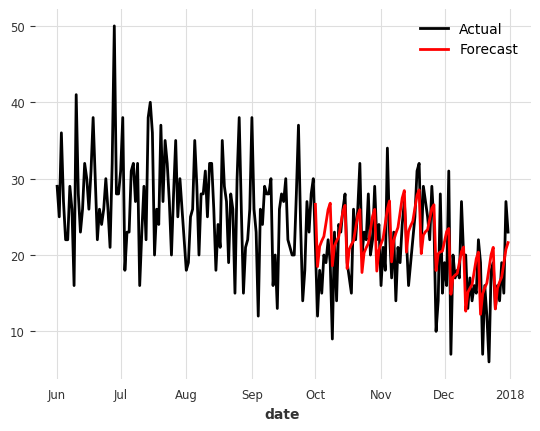

model Prophet() obtains MAPE: 23.80%


In [ ]:
fit_eval_model(Prophet())

It produces the optimal results without requiring any further modifications.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

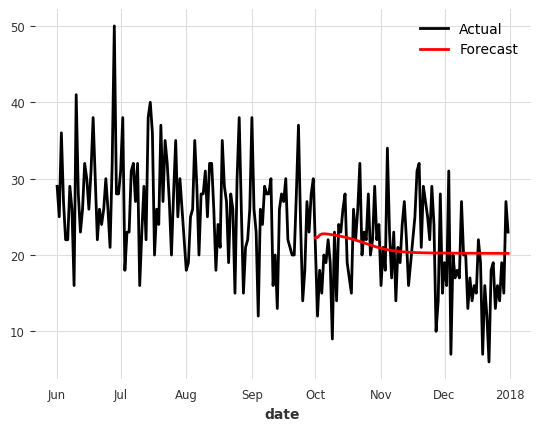

model RNNModel(model=LSTM, input_chunk_length=7) obtains MAPE: 29.52%


In [ ]:
fit_eval_model(RNNModel(model='LSTM', input_chunk_length=7))

It is advisable to normalize the data and optimize the parameters to improve the performance of the RNN model.

In [ ]:
model = Prophet()
model.fit(train)
forecast = model.predict(len(val))
eval_forecast(model, val, forecast);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxeeeqz7h/1vyzr5cv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxeeeqz7h/rgkhek9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75300', 'data', 'file=/tmp/tmpxeeeqz7h/1vyzr5cv.json', 'init=/tmp/tmpxeeeqz7h/rgkhek9r.json', 'output', 'file=/tmp/tmpxeeeqz7h/prophet_modelp5fk2e7n/prophet_model-20241010144105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


model Prophet() obtains MAPE: 23.80%


### Backtest

  0%|          | 0/336 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxeeeqz7h/hgj9gejy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxeeeqz7h/hgmm55n2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75221', 'data', 'file=/tmp/tmpxeeeqz7h/hgj9gejy.json', 'init=/tmp/tmpxeeeqz7h/hgmm55n2.json', 'output', 'file=/tmp/tmpxeeeqz7h/prophet_modelxdxl5s8_/prophet_model-20241010144114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/336 [00:00<02:15,  2.48it/s]INFO:prophet:Disabling daily seasonality. Run prophet wi

MAPE = 20.37%


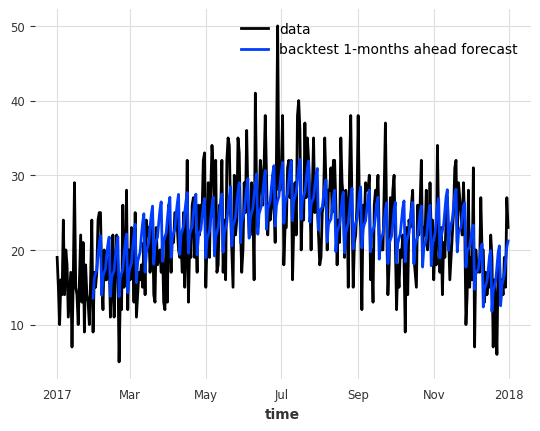

In [ ]:
hfc_params = {
    "series": ts,
    "start": pd.Timestamp("2017-01-01"),
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

ts.slice(pd.Timestamp('2017-01-01'), pd.Timestamp('2018-02-01')).plot(label="data")
historical_fcast.plot(label="backtest 1-months ahead forecast")
print(f"MAPE = {mape(ts.slice(pd.Timestamp('2017-01-01'), pd.Timestamp('2018-02-01')), historical_fcast):.2f}%")

Although it does not closely match the fluctuations in values, it effectively captures the sales spikes observed in July and December.

At this stage, having understood how to model sales for a single item in one store, a systematic approach to forecasting sales for each of the 50 items across 10 stores in the next month would be beneficial.

**Categorization:** It would be prudent to group items and stores based on their sales performance—such as high, medium, and low sales categories. This categorization allows for more tailored modeling approaches that align with the unique characteristics of each group.

**Exploratory Data Analysis (EDA):** Conducting EDA to identify patterns specific to certain items or stores is essential. This analysis will help uncover trends, seasonality, and anomalies in the sales data, informing model selection and feature engineering.

**Modeling Strategy:** For each category, multiple models (2-3) should be trained to evaluate their performance effectively. This approach enables the identification of the model that best captures the sales dynamics for each group.

**Model Selection and Evaluation:** Potential models to consider could include ARIMA, Exponential Smoothing, and XGBoost, depending on the identified patterns during the EDA. The evaluation should focus on metrics such as Mean Absolute Percentage Error (MAPE) and visual inspections of the forecasts to ensure they align with historical trends.

By adopting this structured methodology, it is possible to enhance forecasting accuracy and gain deeper insights into the sales patterns across different items and stores.